In [7]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# Set to True to make .npy file with images, only necessary when running for the first time.
REBUILD_DATA = False

class Make_Data():
    IMG_SIZE = 50
    YES = "brain_tumor_dataset/yes"
    NO = "brain_tumor_dataset/no"
    TESTING = "brain_tumor_dataset/Testing"
    LABELS = {YES: 0, NO: 1}
    converted_data = []

    yes_count = 0
    no_count = 0

    def convert_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.converted_data.append([np.array(img), np.eye(2)[self.LABELS[label]]]) 

                        if label == self.YES:
                            self.yes_count += 1
                        elif label == self.NO:
                            self.no_count += 1

                    except Exception as e:
                        pass


        np.random.shuffle(self.converted_data)
        np.save("data.npy", self.converted_data)
        print('TUMOR:', self.yes_count)
        print('NO TUMOR:', self.no_count)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)


if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


if REBUILD_DATA:
    build_data = Make_Data()
    build_data.convert_data()

converted_data = np.load("data.npy", allow_pickle=True)
print("Number of data samples: ", len(converted_data))



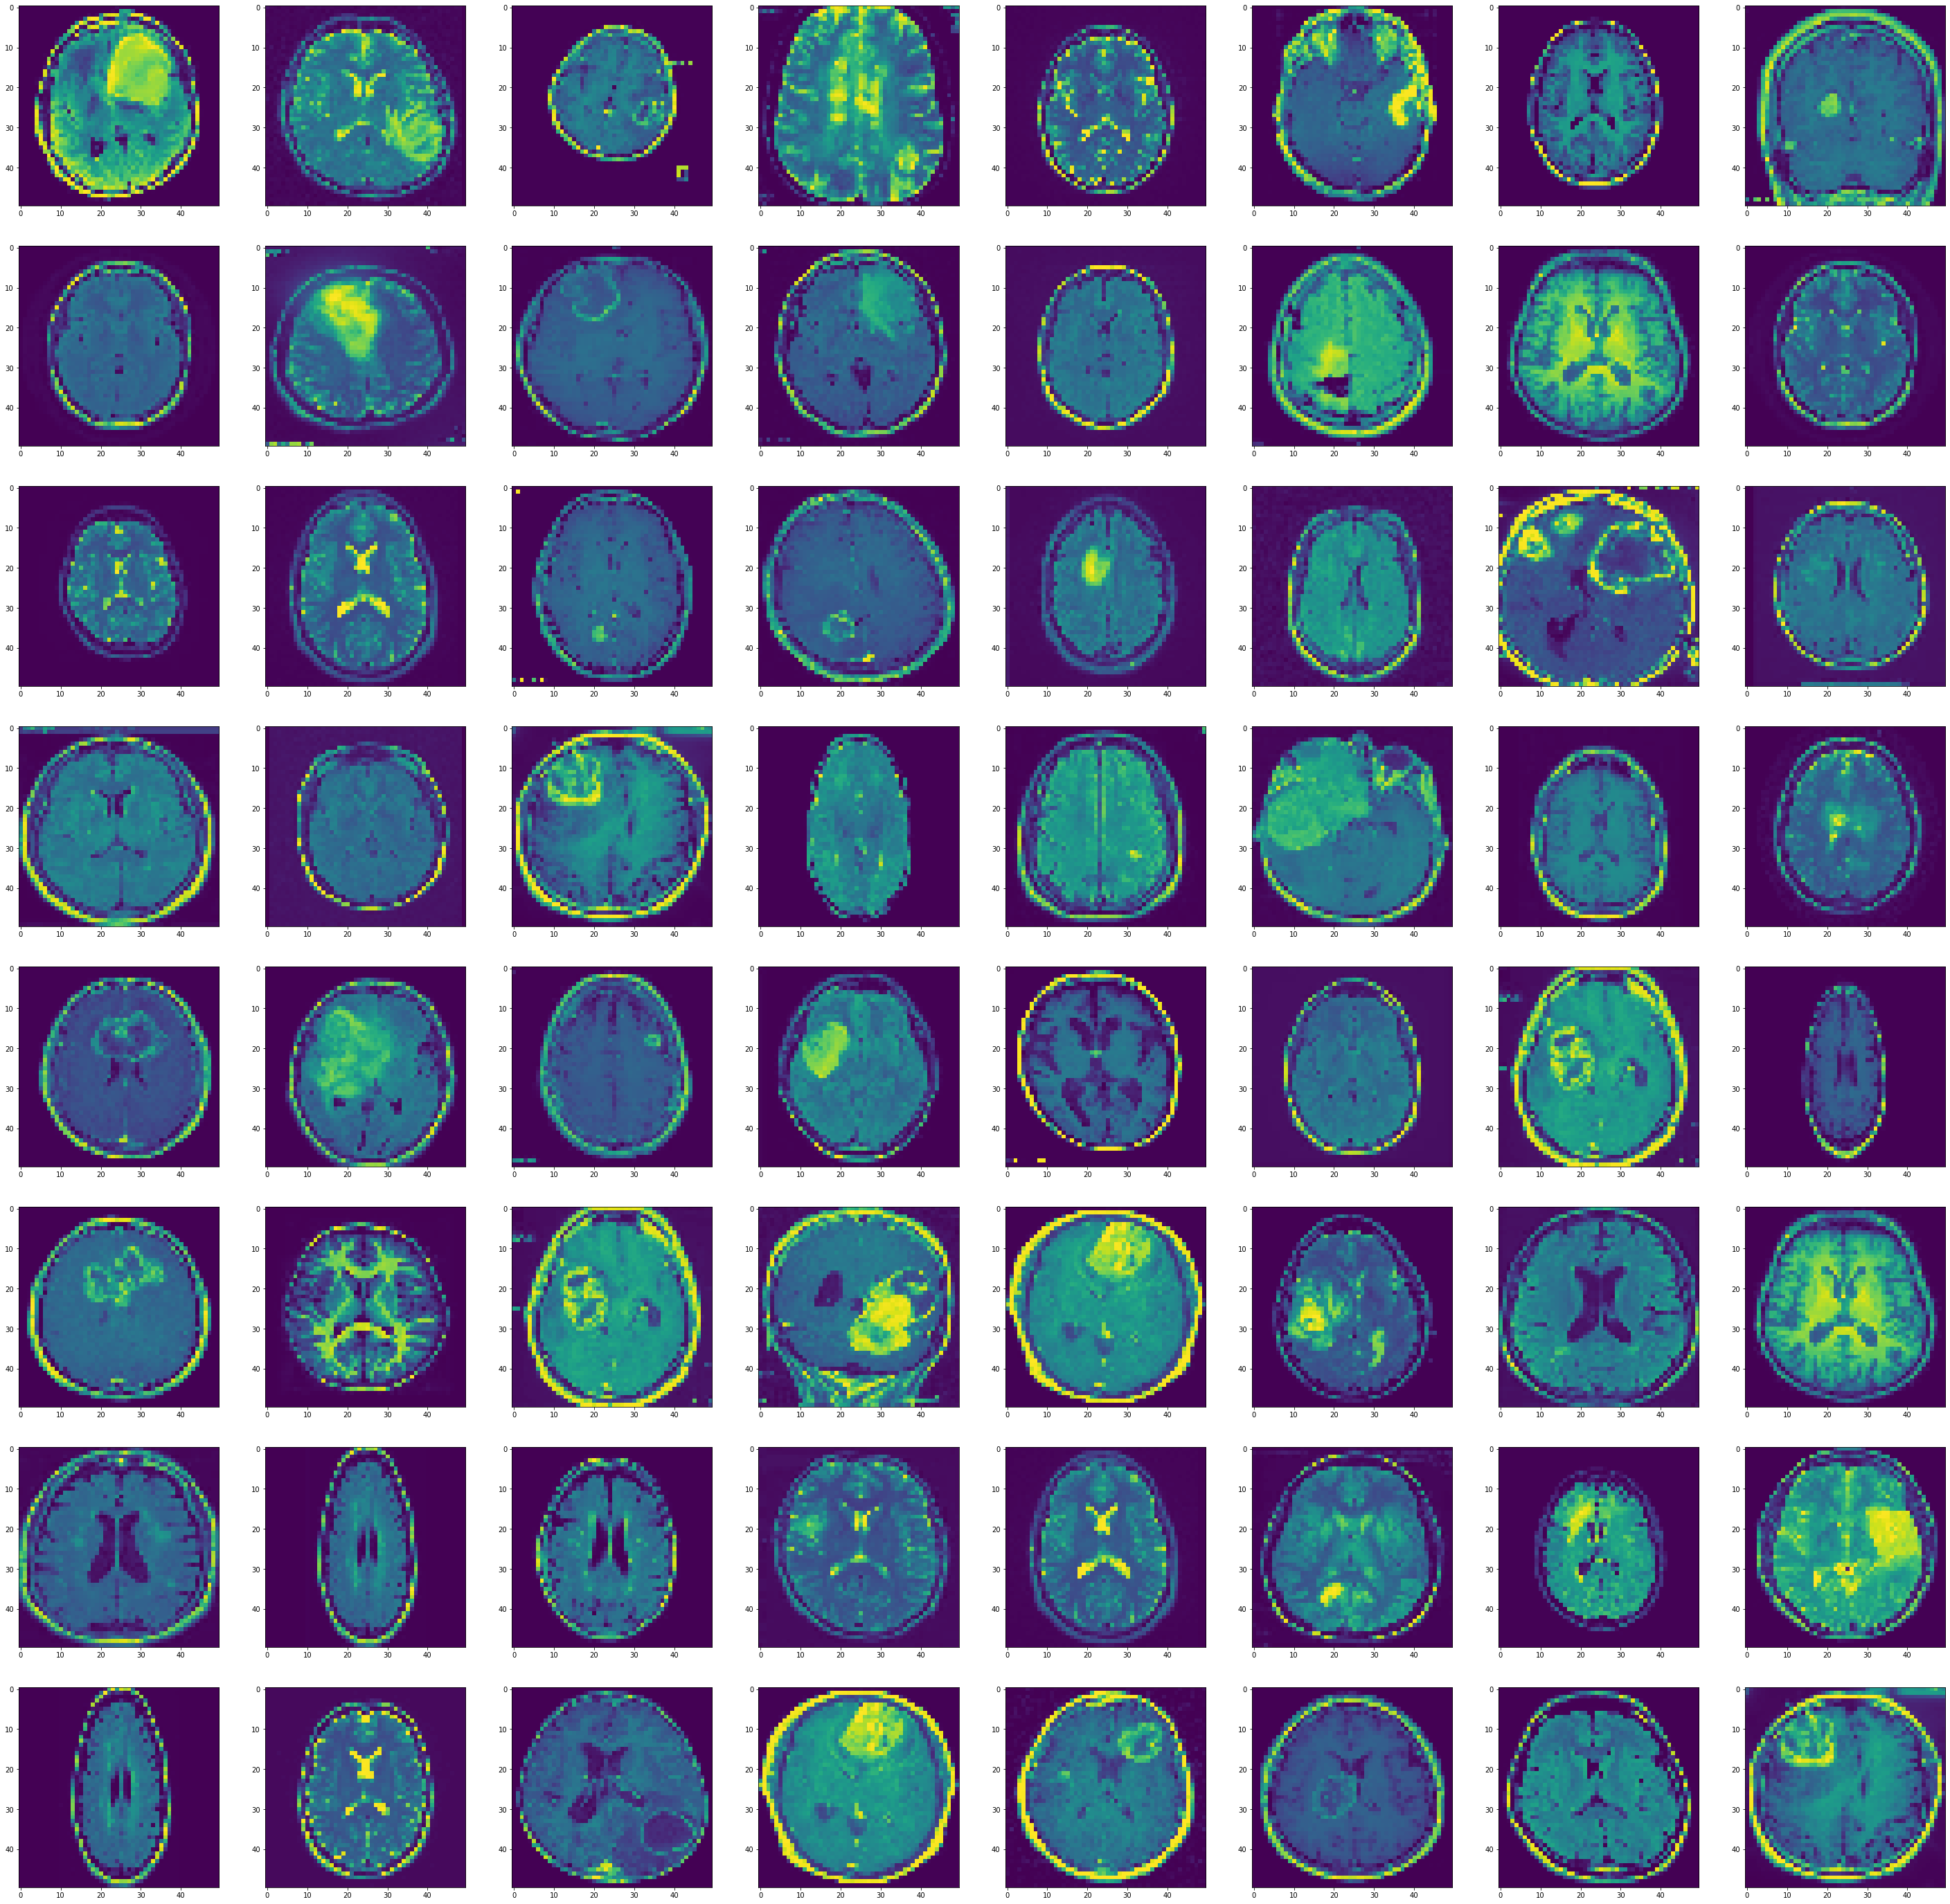

In [13]:
fig = plt.figure(figsize=(50, 50))  # width, height in inches

for i in range(64):
    sub = fig.add_subplot(8, 8, i + 1)
    sub.imshow(converted_data[i,0])
    

In [2]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in converted_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in converted_data])

# percentage for validation dataset
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print("Calculated validation set size: ", val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print("Training samples: ", len(train_X))
print("Test samples: ", len(test_X))


def train(net):
    BATCH_SIZE = 10
    EPOCHS = 10
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}. Loss: {loss}")

def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]

            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy:", round(correct/total,3))
    
train(net)
test(net)

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

Calculated validation set size:  17
Training samples:  154
Test samples:  17


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.24051111936569214
Epoch: 1. Loss: 0.16424062848091125


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 86.15it/s]

Epoch: 2. Loss: 0.14971277117729187



  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

Epoch: 3. Loss: 0.10494653135538101
Epoch: 4. Loss: 0.0612947940826416


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

Epoch: 5. Loss: 0.05453358218073845
Epoch: 6. Loss: 0.060887016355991364


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

Epoch: 7. Loss: 0.0430782288312912
Epoch: 8. Loss: 0.023814085870981216


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 632.96it/s]

Epoch: 9. Loss: 0.030078846961259842
Accuracy: 0.824


In [3]:
# Explore train and test data loss and accuracy over epochs


REBUILD_DATA = False # set to true to one once, then back to false unless you want to change something in your training data.


if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

if REBUILD_DATA:
    dogsvcats = Make_Data()
    dogsvcats.convert_data()

    converted_data = np.load("data.npy", allow_pickle=True)
    print(len(converted_data))

    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_function = nn.MSELoss()

    X = torch.Tensor([i[0] for i in converted_data]).view(-1, 50, 50)
    X = X/255.0
    y = torch.Tensor([i[1] for i in converted_data])

    VAL_PCT = 0.1
    val_size = int(len(X)*VAL_PCT)
    print(val_size)

    train_X = X[:-val_size]
    train_y = y[:-val_size]

    test_X = X[-val_size:]
    test_y = y[-val_size:]


def fwd_pass(X, y, train=False):

    if train:
        net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    return acc, loss



import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def test(size=14):
    rand_start = np.random.randint(len(test_X)-size)
    X,y = test_X[rand_start:rand_start+size], test_y[rand_start:rand_start+size]
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1,1,50,50).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size = 10)



def train(net):
    BATCH_SIZE = 10
    EPOCHS = 30

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                #f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i % 1 == 0:
                    val_acc, val_loss = test(size=14)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{epoch},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")
train(net)



  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

Running on the GPU


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 59.57it/s]


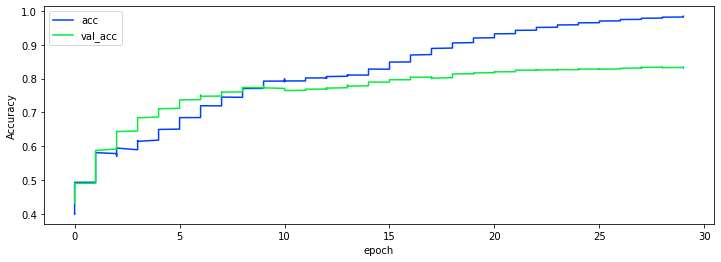

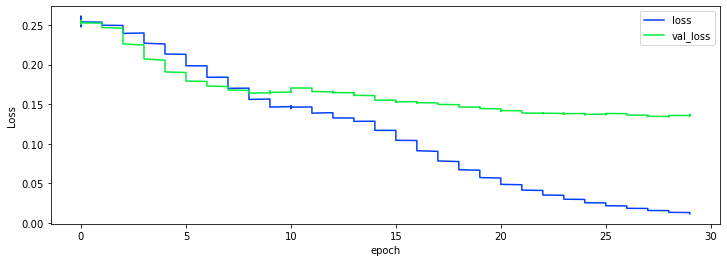

In [14]:
# weighted moving average

def create_acc_loss_graph(model_name):
    style.use('seaborn-bright')
    data = pd.read_csv('model.log', names=['model_name', 'timestamp', 'epoch', 'acc', 'loss', 'val_acc', 'val_loss'])
    data = data[data.model_name == MODEL_NAME]
    
    # Convert to weighted moving average
    for row in ['acc', 'loss', 'val_acc', 'val_loss']:
        data[row] = data[row].ewm(alpha=.01).mean()
    # Plot it
    data[['epoch', 'acc', 'val_acc']].plot(x='epoch', figsize=(12,4))  # Replace 'epoch' with 'timestamp' to change the horizontal axis
    plt.ylabel('Accuracy')
    data[['epoch', 'loss', 'val_loss']].plot(x='epoch', figsize=(12,4))  # Replace 'epoch' with 'timestamp' to change the horizontal axis
    plt.ylabel('Loss')


create_acc_loss_graph('model-1601991236')

In [6]:
# Best accuracy achieved after 7 epochs

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train(net):
    BATCH_SIZE = 10
    EPOCHS = 9
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}. Loss: {loss}")

def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]

            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy:", round(correct/total,3))
    
train(net)
test(net)

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.24783222377300262
Epoch: 1. Loss: 0.23183317482471466


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

Epoch: 2. Loss: 0.17345073819160461
Epoch: 3. Loss: 0.1061740592122078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 83.77it/s]

Epoch: 4. Loss: 0.082484669983387



 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:00<00:00, 98.68it/s]

Epoch: 5. Loss: 0.06127104163169861


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 88.44it/s]

Epoch: 6. Loss: 0.08024080097675323



100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 486.05it/s]

Epoch: 7. Loss: 0.097853884100914
Epoch: 8. Loss: 0.10687239468097687
Accuracy: 0.824


### Final accuracy of 82%